In [85]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

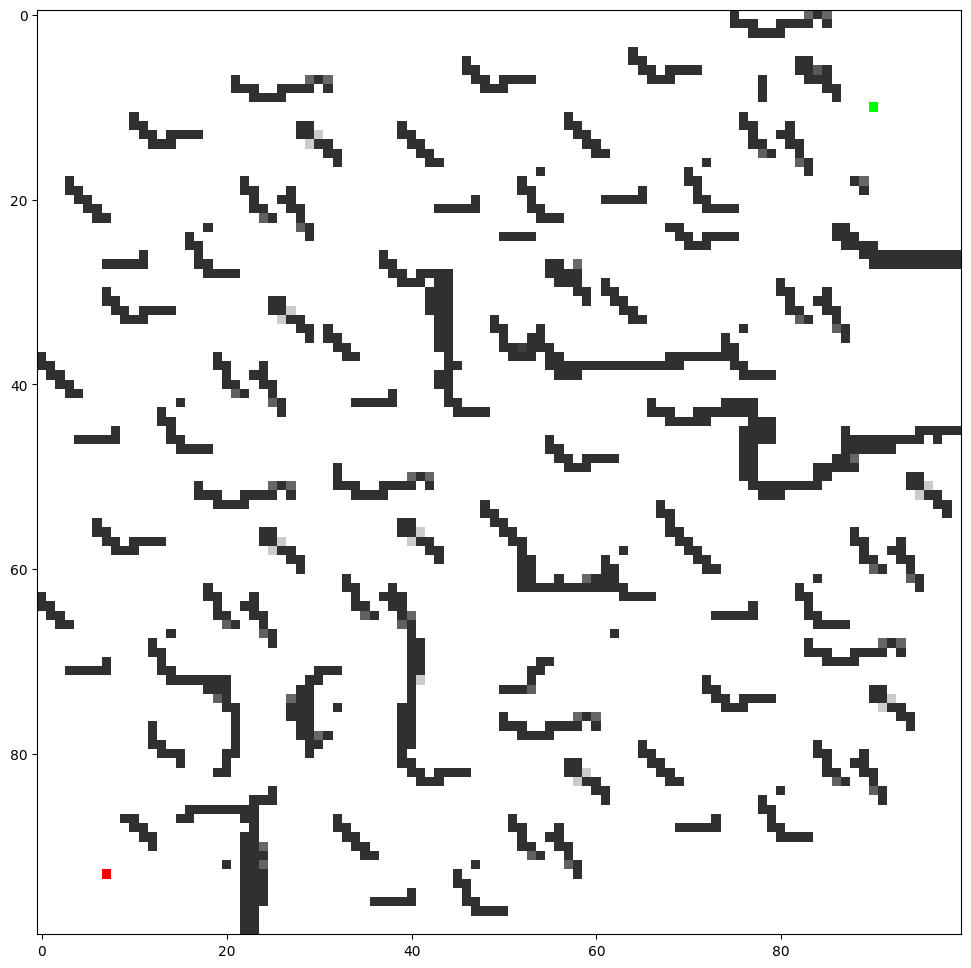

In [86]:
img = np.asarray(Image.open('pic8.png'))
plt.rcParams['figure.figsize'] = [12, 12]
imgplot = plt.imshow(img)

#### Class `Point`
Definiert einen Punkt mit folgenden Parametern:
- `x`: x-Position des Punktes
- `y`: y-Position des Punkter
- `g_cost`: Der Kostenwert um diesen Punkt zu erreichen
- `h_cost`: Der Kostenwert um diesen Punkt zu erreichen
- `f_cost`: Der Kostenwert um diesen Punkt zu erreichen
- `isActive`: Besagt ob der Punkt aktiv ist bzw. ob er für den Pfad relevant ist
- `distanceToTarget`: Ist die Distanz zum Ziel

In [87]:
class Point:
    def __init__(self, x, y, g_cost=0, h_cost=0, isVisited=False):
        self.x = x
        self.y = y
        self.g_cost = g_cost #distance from starting point
        self.h_cost = h_cost #distance form end point
        self.f_cost = g_cost + h_cost #sum of H cost and G cost
        self.isVisited = isVisited,
    
    def updateCost(self, g_cost, h_cost):
        self.g_cost = g_cost
        self.h_cost = h_cost
        self.f_cost = g_cost + h_cost



#### Function `getPointByColor`
Gibt einen Punkt zurück, welcher die entsprechende Farbe hat. Es wird nur der letzte gefundene Punkt zurückgegeben.
- `r`: Rotwert von 0-255
- `g`: Grünwert von 0-255
- `b`: Blauwert von 0-255
- `image`: Bildarray in dem der Punkt gesucht werden soll

In [88]:
def getPointByColor(r, g, b, image):
    x, y = 0, 0
    for idi, i in enumerate(image):
        for idj, j in enumerate(i):
            if j[0] == r and j[1] == g and j[2] == b:
               x = idj
               y = idi
    return Point(x ,y)


Der grüne Startpunkt und der rote Zielpunkt wird mithilfe der Funktion `getPointByColor` definiert.

In [89]:
startPoint = getPointByColor(0, 255, 0, img)
endPoint = getPointByColor(255, 0, 0, img)
print(f'StartPoint = {startPoint}\nEndPoint = {endPoint}')

StartPoint = <__main__.Point object at 0x11b106320>
EndPoint = <__main__.Point object at 0x1036cdff0>


#### Function `isWall`
Gibt zurück, ob entsprechneder Punkt eine Wand ist oder nicht. Wenn die Farbe des Punktes in allen drei Farben einen geringeren Wert als 128 aufweisst, wird er als Wand definiert.
- `point:Point`: Punkt der auf eine Wand geprüft werden soll.
- `image`: Bildarray auf dem der Punkt ist

In [90]:
def isWall(point:Point, image):
    x = point.x
    y = point.y
    if x < image.shape[1] and y < image.shape[0]:
        if image[y][x][0] < 128 and image[y][x][1] < 128 and image[y][x][2] < 128: return True
        else: return False
    else: return False


def getDistance(pointStart:Point, pointTarget:Point):
    return np.sqrt(np.abs(pointStart.x-pointTarget.x)**2 + np.abs(pointStart.y-pointTarget.y)**2)

#### Function `getNextPoints`
Gibt eine List von Punkten zurück, die vom gegebenen Punkt benachbart sind. Wenn ein benachbarter Punkt eine Wand darstellt, wird dieser ignoriert.
- `point:Point`: Punkt von dem aus die benachbarten Punkte gesucht werden
- `image`: Bildarray auf dem der Punkt ist

In [91]:
def getNextPointsFromMap(point:Point, image):
    maxPos = image.shape
    nextPoints = []
    for i in np.arange(-1,2,1):
        for j in np.arange(-1,2,1):
            if i != 0 or j != 0:
                xn = point.x+i
                yn = point.y+j
                if xn >= 0 and yn >= 0 and xn <= maxPos[1] and yn <= maxPos[0] and not isWall(Point(xn, yn), image):
                    if xn != startPoint.x or yn != startPoint.y:
                        if xn < image.shape[1] and yn < image.shape[0]:
                            nextPoints.append(Point(xn, yn))
    return nextPoints

In [92]:
def isPointInList(point:Point, pointList:list[Point]):
    wasFound = False
    for p in pointList:
        if p.x == point.x and p.y ==point.y: wasFound = True
    return wasFound

In [93]:
def getPointFromList(point:Point, pointList:list[Point]):
    for p in pointList:
        if p.x == point.x and p.y ==point.y: return p

In [94]:
def isNeighbourPoint(pointOfIntrest:Point, potantialPoint:Point):
    if np.abs(pointOfIntrest.x - potantialPoint.x) >1 or np.abs(pointOfIntrest.y - potantialPoint.y) >1:
        return False
    if pointOfIntrest.x == potantialPoint.x and pointOfIntrest.y == potantialPoint.y:
        return False
    else: return True

#### Function `calculateNextPoints`
Gibt eine List von Punkten zurück, die benachbart sind vom gegeben Punkt und berechnet die Kosten um den Punkt zu erreichen und berechnet die Distanz zum Zielpunkt.
- `point:Point`: Punkt von dem aus die benachbarten Punkte berechnet werden
- `image`: Bildarray auf dem der Punkt ist
- `precision`: Auf wieviele Stellen nach dem Komma gerundet werden soll bezüglich der Kosten

In [95]:
def calculateNextPoints(point:Point, image, pointList:list[Point]=[]):
    nextPoints = getNextPointsFromMap(point, image)

    distance = 1
    distanceDiagonal = 1.4

    if len(pointList) > 0:
        for p in pointList:
            if isNeighbourPoint(p, point):
                if p.x != point.x and p.y != point.y:
                    cost = distanceDiagonal
                else:
                    cost = distance
                    
                distanceToTarget = getDistance(p, endPoint)
                newGCost = point.g_cost + cost
        
                if p.g_cost > newGCost:
                    p.updateCost(newGCost, distanceToTarget)

    for p in nextPoints:
        if p.x != point.x and p.y != point.y:
            cost = distanceDiagonal
        else:
            cost = distance
            
        distanceToTarget = getDistance(p, endPoint)
        newGCost = point.g_cost + cost

        if p.g_cost > newGCost:
            p.updateCost(newGCost, distanceToTarget)

        if not isPointInList(p, pointList):
            pointList.append(Point(p.x, p.y ,newGCost, distanceToTarget))       

    return pointList

In [96]:
def plotImage(image, points):
    for point in points:
        label = f'{round(point.g_cost,1)}   {round(point.h_cost,1)}'
        plt.text(point.x, point.y, label, ha='center',va='bottom',fontsize=10)
        label = f'{round(point.f_cost,1)}'
        plt.text(point.x, point.y, label, ha='center',va='top',fontsize=14)

    plt.imshow(image)

In [97]:
def getClosestPointToTarget(points:list[Point]):
    bestPoint:Point = Point(-1,-1,float('inf'),float('inf'),False)
    minDistanceToTarget = float('inf')
    for point in points:
        if point.h_cost < minDistanceToTarget:
            minDistanceToTarget = point.h_cost
            bestPoint = point
def getNextPointsFromMap(point:Point, image):
    maxPos = image.shape
    nextPoints = []
    for i in np.arange(-1,2,1):
        for j in np.arange(-1,2,1):
            if i != 0 or j != 0:
                xn = point.x+i
                yn = point.y+j
                if xn >= 0 and yn >= 0 and xn <= maxPos[1] and yn <= maxPos[0] and not isWall(Point(xn, yn), image):
                    if xn != startPoint.x or yn != startPoint.y:
                        if xn < image.shape[1] and yn < image.shape[0]:
                            nextPoints.append(Point(xn, yn))
    return nextPoints

In [98]:
def getLowestHCostPoint(points:list[Point]):
    bestHCostPoints:Point = Point
    minHCost = float('inf')
    for p in points:
            if p.h_cost < minHCost:
                minHCost = p.h_cost
                bestHCostPoints = p

    return bestHCostPoints

In [99]:
def getLowestUnvisitedFCostPoints(points:list[Point]):
    bestPoint = Point
    bestFCostPoints:list[Point] = []
    minFCost = float('inf')
    for p in points:
        if p.isVisited is not True:
            if p.f_cost <= minFCost:
                minFCost = p.f_cost
                #bestPoint = p
                #bestFCostPoints.append(bestPoint)

    for p in points:
        if p.f_cost <= minFCost*1.05 and p.isVisited is not True: bestFCostPoints.append(p)
    

    if len(bestFCostPoints) > 1:
        bestPoint = getLowestHCostPoint(bestFCostPoints)
    else:
        bestPoint = bestFCostPoints[0]

    return bestPoint

In [100]:
p1 = Point(0, 0, 10, 30)
p2 = Point(0, 0, 30, 10)
p3 = Point(0, 0, 20, 20)
p4 = Point(0, 0, 30, 30)

p = [p1, p2, p3, p4]

point = getLowestUnvisitedFCostPoints(p)

print(f'f={point.f_cost}\tg={point.g_cost}\th={point.h_cost}')

f=40	g=30	h=10


In [101]:
def printPlotDetail(pointList:list[Point], image, iterations, record=False):

    maxDimension = max(image.shape)

    if maxDimension > 16: plt.imshow(img)
    else: plotImage(img, pointList)

    print(f'Iterationen: {iterations}')

    sd = 250000/maxDimension**2
    yellow_x = []
    yellow_y = []
    orange_x = []
    orange_y = []
    for p in pointList:
        if p.isVisited is not True:
            yellow_x.append(p.x)
            yellow_y.append(p.y)
        else:
            orange_x.append(p.x)
            orange_y.append(p.y)

    plt.scatter(x=orange_x, y=orange_y, c='orange', marker='s', s=sd)
    plt.scatter(x=yellow_x, y=yellow_y, c='yellow', marker='s', s=sd)

    if record is True: plt.savefig(f'Test/{iterations}_Iteration_V2')



In [102]:
pointList = calculateNextPoints(startPoint, img)
maxDimension = max(img.shape)
distanceToTarget = float('inf')
iterations = 0
MAX_ITERATION = maxDimension**2

while distanceToTarget > 1.5 and iterations < MAX_ITERATION:
    point = getLowestUnvisitedFCostPoints(pointList)
    point.isVisited = True
    distanceToTarget = point.h_cost
    pointList = calculateNextPoints(point, img, pointList)
    iterations += 1
    #printPlotDetail(pointList, img, iterations, True)
    #plt.close()

In [103]:
#printPlotDetail(pointList, img, iterations)

In [104]:
def getEndPoint(points:list[Point]):
    endPoint = 0
    for p in points:
        if p.h_cost < 1:
            endPoint = p
            break
    return endPoint

def getNextPointsFromList(point:Point, pointList:list[Point]):
    nextPoints = []
    for p in pointList:
        if isNeighbourPoint(point, p): nextPoints.append(p)
    return nextPoints

def getNextPathPoint(pointlist:list[Point]):
    minGCost = float('inf')
    bestGCostPoint = 0
    for p in pointlist:
        if p.g_cost < minGCost:
            minGCost = p.g_cost
            bestGCostPoint = p
    
    return bestGCostPoint


def getPath(points:list[Point]):
    path = []

    distanceToStart = float('inf')
    iterations = 1
    print(endPoint.x, endPoint.y)
    nextPoints = getNextPointsFromList(endPoint, points)
    nextPoint = getNextPathPoint(nextPoints)
    path.append(nextPoint)

    while distanceToStart > 1.5 and iterations < maxDimension**2:
        nextPoints = getNextPointsFromList(nextPoint, points)
        nextPoint = getNextPathPoint(nextPoints)
        distanceToStart = nextPoint.g_cost

        path.append(nextPoint)
        iterations += 1

    return path, iterations

7 93
Steps to Target: 108
Iterationen: 108


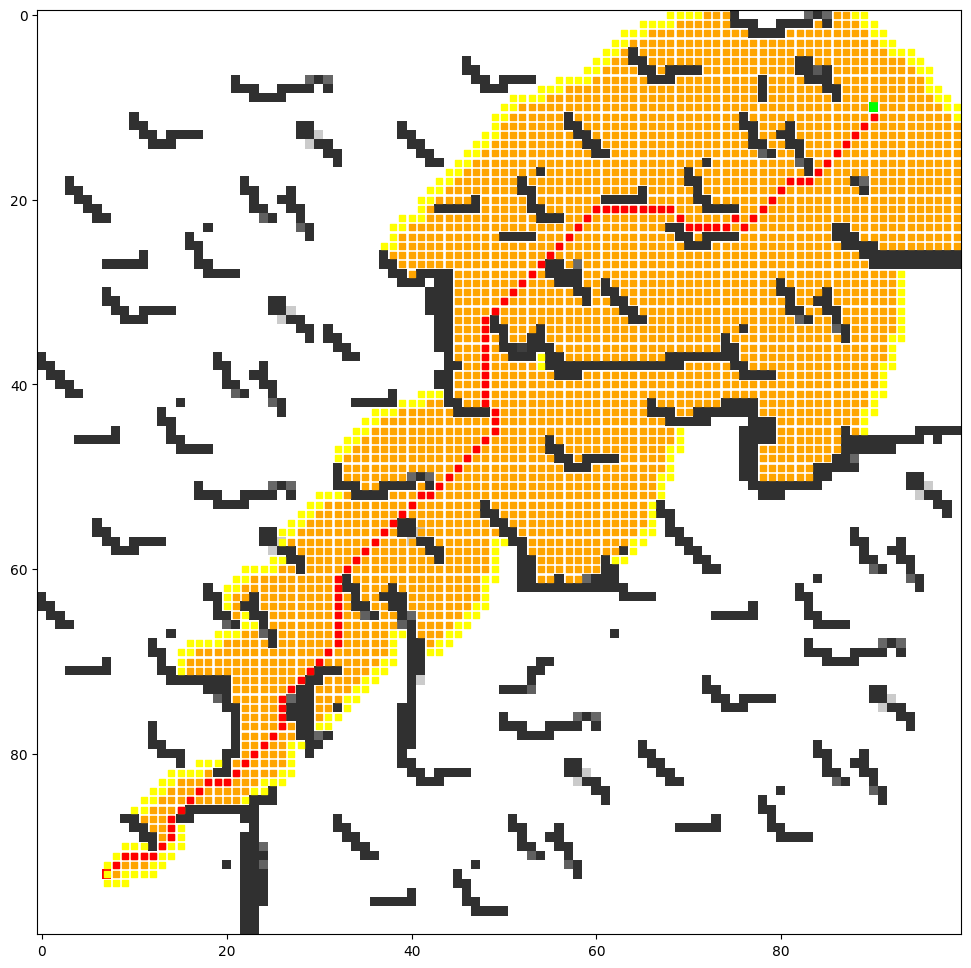

In [105]:
path, iterations= getPath(pointList)

print(f'Steps to Target: {iterations}')

maxDimension = max(img.shape)
sd = 250000/maxDimension**2

printPlotDetail(pointList, img, iterations)
for p in path:
    plt.scatter(p.x, p.y, c='red', marker='s', s=sd)